Shows how to create a vacuum and dark dress binary and compute their relative dephasing.

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from pydd.analysis import calculate_SNR, calculate_match_unnormd_fft, get_match_pads, loglikelihood_fft
from pydd.binary import (
    DynamicDress,
    MSUN,
    PC,
    Phi_to_c,
    _Phi_to_c_indef,
    VacuumBinary,
    convert,
    get_M_chirp,
    get_rho_s,
    AccretionDisk,
    GravAtom,
    get_f_isco,
    get_rho_6,
    get_f_range,
    get_m_1,
    get_m_2,
    make_dynamic_dress,
    make_vacuum_binary,
    make_accretion_disk,
    make_grav_atom,
    t_to_c,
    YR,
    master_call
)

import pickle
from typing import Tuple

import dynesty
from dynesty import plotting as dyplot

from tqdm.auto import trange


from scipy.optimize import minimize_scalar
import numpy as np
import scipy.special as sc
from scipy import integrate
import math
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import simps

200


/Users/pippacole/Dropbox/Mac/Documents/dec-pydd-main-2/src/pydd/binary.py:356: RuntimeWarning: invalid value encountered in log10
  vals_neg = np.log10(1 - hypgeom_scipy(-b_mg[::-1, :], z_mg))


In [122]:
# Intrinsic parameters of astrophysical benchmark
m1 = 1e5 * MSUN
m2 = 10 * MSUN
#rho_6 = 0.5e16 * MSUN / PC ** 3
rho_6=5.448e15 * MSUN / PC ** 3 * 1e2
gamma_s = 7 / 3
Sig0 = 1e7 #kg/m^2
Mch = 10.0
t_obs_lisa = 5 * YR
alpha = 0.2
eps_init = 1e-2

hi_sig = 1e4 * (1e-3)/(1e-4)
lo_sig = 1e4
hi_mch = 30
lo_mch = 10

hisigm2 = hi_sig * hi_mch**2

# Extrinsic parameters
Phi_c = 0.0  # GW phase at coalescence
t_c = 0.0  # reference time at coalescence
dL = 1e8 * PC  # luminosity distance

# Construct dark dress, grav atom, acc disc and vacuum system. These functions set up (almost all)
# the intermediate variables.
rho_s = get_rho_s(rho_6, m1, gamma_s)
dd = make_dynamic_dress(m1, m2, rho_6, gamma_s, Phi_c, t_c, dL)
vb = make_vacuum_binary(m1, m2, Phi_c, t_c, dL)
dg = make_grav_atom(m1, m2, alpha, eps_init, Phi_c, t_c, dL)
dg2 = make_grav_atom(m1, m1*(1e-4 * 10**(3e-5)), 0.2, 1e-2, Phi_c, t_c, dL)
vbf = make_vacuum_binary(m1 * 30, m2*30, Phi_c, t_c, dL)
ad_hi_sig_hi_mch = make_accretion_disk(m1, m2, hisigm2, Phi_c, t_c, dL)
#ad_hi_sig_lo_mch = make_accretion_disk(m1, m2, hi_sig, lo_mch, Phi_c, t_c, dL)
#ad_lo_sig_hi_mch = make_accretion_disk(m1, m2, lo_sig, hi_mch, Phi_c, t_c, dL)
#ad_lo_sig_lo_mch = make_accretion_disk(m1, m2, lo_sig, lo_mch, Phi_c, t_c, dL)

# Plot phase and dephasing 

NameError: name 'gimmy_x' is not defined

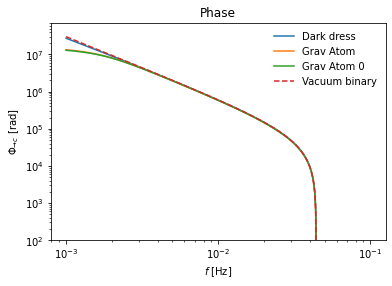

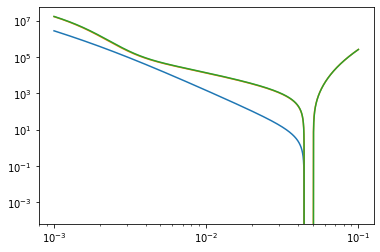

In [7]:
plt.figure(figsize=(6, 4))

fs = np.logspace(-3,-1,50000)#[jnp.geomspace(f_l_list[i], get_f_isco(m1), 1000) for i in range(len(f_l_list))]
plt.loglog(fs, Phi_to_c(fs, dd), label="Dark dress")
#plt.loglog(fs[1], Phi_to_c(fs[1], vbf), "--", label="Vacuum best-fit binary")
#plt.loglog(fs[2], Phi_to_c(fs[2], ad_hi_sig_hi_mch ), label="Accretion Disk")
plt.loglog(fs, Phi_to_c(fs, dg), label="Grav Atom")
plt.loglog(fs, Phi_to_c(fs, dg2), label="Grav Atom 0")
plt.loglog(fs, Phi_to_c(fs, vb), "--", label="Vacuum binary")
plt.xlabel(r"$f$ [Hz]")
plt.ylabel(r"$\Phi_{\to c}$ [rad]")
plt.ylim(1e2,)
plt.legend(frameon=False)
plt.title("Phase")
#plt.savefig('ga_phase_test.pdf')

plt.figure(figsize=(6,4))
#fs = [jnp.geomspace(f_l_list[i], get_f_isco(m1), 1000) for i in range(len(f_l_list))]
#fsvbf = jnp.geomspace(f_l_vbf, get_f_isco(mbf),1000)
plt.loglog(fs, Phi_to_c(fs, vb) - Phi_to_c(fs, dd),label=r"Dark Dress")
#plt.loglog(fs, Phi_to_c(fs, vb) - Phi_to_c(fs, vbf),label=r"Best fit vacuum")
plt.loglog(fs, Phi_to_c(fs, vb) - Phi_to_c(fs, dg),label=r"GravAtom")
plt.loglog(fs, Phi_to_c(fs, vb) - Phi_to_c(fs, dg2),label=r"GravAtom 0 mc")
plt.loglog(gimmy_x,gimmy_y,color = 'magenta')


#plt.loglog(fsvbf, -Phi_to_c(fsvbf, vb) + Phi_to_c(fsvbf, vbf),label=r"Best fit vacuum")#r"$\Phi_{\to c,\mathrm{V}} - \Phi_{\to c,\mathrm{D}}$ [rad]")
#plt.loglog(fs[2], -(Phi_to_c(fs[2], vb) - Phi_to_c(fs[2], ad_hi_sig_hi_mch)),label=r"Disk, $\Sigma=10^7\,kg/m^2$, $M=30$")#r"$-\Phi_{\to c,\mathrm{V}} + \Phi_{\to c,\mathrm{A}}$ [rad],")
#plt.loglog(fs[3], -(Phi_to_c(fs[3], vb) - Phi_to_c(fs[3], ad_hi_sig_lo_mch)),label=r"Disk, $\Sigma=10^7\,kg/m^2$, $M=10$")#r"$-\Phi_{\to c,\mathrm{V}} + \Phi_{\to c,\mathrm{A}}$ [rad]")
#plt.loglog(fs[4], -(Phi_to_c(fs[4], vb) - Phi_to_c(fs[4], ad_lo_sig_hi_mch)),label=r"Disk, $\Sigma=10^4\,kg/m^2$, $M=30$")#r"$-\Phi_{\to c,\mathrm{V}} + \Phi_{\to c,\mathrm{A}}$ [rad]")
#plt.loglog(fs[5], -(Phi_to_c(fs[5], vb) - Phi_to_c(fs[5], ad_lo_sig_lo_mch)),label=r"Disk, $\Sigma=10^4\,kg/m^2$, $M=10$")#r"$-\Phi_{\to c,\mathrm{V}} + \Phi_{\to c,\mathrm{A}}$ [rad]")
plt.xlabel(r"$f$ [Hz]")

plt.legend()
plt.title("Dephasing")

plt.tight_layout()

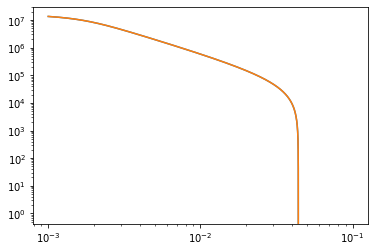

In [124]:
plt.loglog(fs, Phi_to_c(fs, dg), label="Grav Atom")
plt.loglog(fs, Phi_to_c(fs, dg2), label="Grav Atom")
#plt.xlim(4e-2,4.1e-2)

In [27]:
f_l = 1e-4
f_h = 0.04
n_f = 100000
def get_loglikelihood_fn_v(dd_s, f_l=f_l, f_h=f_h, n_f=n_f):
    """
    x: parameter point
    dd_s: signal system
    """
    # Unpack parameters into dark dress ones
    fs = jnp.linspace(f_l, f_h, n_f)
    pad_low, pad_high = get_match_pads(fs)

    def _ll(x):
        M_chirp_MSUN = x
        M_chirp = M_chirp_MSUN * MSUN
        dd_h = VacuumBinary(M_chirp, dd_s.Phi_c, dd_s.tT_c, dd_s.dL, dd_s.f_c)
        return loglikelihood_fft(dd_h, dd_s, fs, pad_low, pad_high)

    return _ll

def fit_v(dd_s: GravAtom, f_l) -> VacuumBinary:
    """
    Find best-fit vacuum system.
    """
    loglikelihood_v = get_loglikelihood_fn_v(dd_s, f_l, dd_s.f_c, n_f=10000000)
    fun = lambda x: -loglikelihood_v(x)
    bracket = (dd_s.M_chirp / MSUN , dd_s.M_chirp / MSUN + 15)
    res = minimize_scalar(fun, bracket, tol=1e-15)

    assert res.success

#    bracket_range = np.linspace(dd_s.M_chirp / MSUN, dd_s.M_chirp / MSUN + 1e-1,100)
#    ll_list = [-fun(bracket_range[i]) for i in range(len(bracket_range))]
#    plt.figure(figsize=(10, 7))
#    plt.loglog(bracket_range*MSUN,ll_list)
#    plt.show()

    return VacuumBinary(
        res.x * MSUN,
        dd_s.Phi_c,
        dd_s.tT_c,
        dd_s.dL,
        dd_s.f_c,
    )


In [28]:
fit_v(GA_D,FS[0])

KeyboardInterrupt: 

In [87]:
def ptform_v(u):
    assert u.shape == (1,)
    v_m = np.array([2])
    return 2 * v_m * (u - 0.5)


def unpack_v(x):
    dMc_MSUN = x[0]
    Mc = (15 * MSUN) + GA_D.M_chirp + (dMc_MSUN * MSUN)

    m_1 = get_m_1(Mc, GA_D.q)
    f_c = get_f_isco(m_1)
    return VacuumBinary(Mc, GA_D.Phi_c, GA_D.tT_c, GA_D.dL, GA_D.f_c)


#@jax.jit
def get_ll_fft(x):
    vb_h = unpack_v(x)
    return loglikelihood_fft(vb_h, GA_D, FS, PAD_LOW, PAD_HIGH, S_n)

In [63]:
vcheck = VacuumBinary(GA_D.M_chirp, GA_D.Phi_c, GA_D.tT_c, GA_D.dL, GA_D.f_c)

In [86]:
Phi_to_c(FS, vcheck)/Phi_to_c(FS, GA_D)

array([1.08420678, 1.08416691, 1.08412616, ..., 1.03863385, 1.03860806,
       1.03841727])

In [88]:
# Sample points and compute likelihood
xs = []
lls = []

for _ in trange(200):
    xs.append(ptform_v(np.random.rand(1)))
    lls.append(get_ll_fft(xs[-1]))

xs = jnp.array(xs)
lls = jnp.array(lls)

  0%|          | 0/200 [00:00<?, ?it/s]

# NS stuff

In [2]:
# Set detector
detector = "LISA"

In [3]:
# Set noise and other globals based on detector
if detector == "et":
    from pydd.noise import S_n_et as S_n, f_range_et as f_range_n  # ET

    T_OBS = 1 * YR
    SNR_THRESH = 12.0
    TITLE = "Einstein Telescope"
elif detector == "ce":
    from pydd.noise import S_n_ce as S_n, f_range_ce as f_range_n  # CE

    T_OBS = 1 * YR
    SNR_THRESH = 12.0
    TITLE = "Cosmic Explorer"
elif detector == "aLIGO":
    from pydd.noise import S_n_aLIGO as S_n, f_range_aLIGO as f_range_n  # aLIGO

    T_OBS = 1 * YR
    SNR_THRESH = 12.0
    TITLE = "aLIGO"
elif detector == "LISA":
    from pydd.noise import S_n_LISA as S_n, f_range_LISA as f_range_n  # LISA

    T_OBS = 5 * YR
    SNR_THRESH = 15.0
    TITLE = "LISA"

In [4]:
def get_signal_system() -> Tuple[GravAtom, Tuple[float, float]]:
    """
    Creates a gravitational atom with correct SNR for given detector.
    
    Returns:
        The dark dress and frequency range corresponding to an observing time
        of ``T_OBS`` before coalescence.
    """
    M_1 = np.array(1e5 * MSUN)
    M_2 = np.array(10 * MSUN)
    M_CHIRP = get_M_chirp(M_1, M_2)
    Q = M_2 / M_1
    alph = 0.2
    eps_init = 1e-2
    TT_C = np.array(0.0)
    F_C = get_f_isco(M_1)
    PHI_C = np.array(0.0)
    _GA_D = GravAtom(
        alph,
        eps_init,
        get_M_chirp(M_1, M_2),
        M_2 / M_1,
        PHI_C,
        tT_c=TT_C,
        dL=np.array(100e6 * PC),
        f_c=get_f_isco(M_1),
    )

    ftest = lambda f_l: (t_to_c(f_l, _GA_D) - T_OBS)**2
    res = minimize_scalar(ftest, bracket=(2e-3,2e-2))
    if not res.success:
        raise RuntimeError(f"finding f_l failed: {res}")
    f_ltest = res.x
    print(f_ltest)
    
    ftest = lambda f_l: (t_to_c(f_l, _GA_D) - _GA_D.tT_c)**2
    res = minimize_scalar(ftest, bracket=(4e-2,4.4e-2), bounds=(4e-2,4.4e-2), method='bounded')
    if not res.success:
        raise RuntimeError(f"finding f_l failed: {res}")
    f_htest = res.x
    print(f_htest)
    
    print(t_to_c(f_htest,_GA_D))

    
    # Frequency range and grids
 #   F_RANGE_D = get_f_range(_GA_D, T_OBS, bracket = (2e-3,2e-2))
    F_RANGE_D = f_ltest, f_htest
    FS = np.linspace(
        max(f_ltest, f_range_n[0]), min(f_htest, f_range_n[1]), 10_000
    )
 #   print(F_RANGE_D)
  #  print(calculate_SNR(_GA_D,FS,S_n))

    # Get dL
    _fn = lambda dL: calculate_SNR(
            GravAtom(
                _GA_D.alpha,
                _GA_D.epsilon_init,
                _GA_D.M_chirp,
                _GA_D.q,
                _GA_D.Phi_c,
                _GA_D.tT_c,
                dL,
                _GA_D.f_c,
            ),
            FS,
            S_n,
        )
    
    print(_fn(100000e6))
    res = root_scalar(
        lambda dL: (_fn(dL) - SNR_THRESH), bracket=(0.1e6 * PC, 100000e8 * PC)
    )
    assert res.converged
    DL = res.root

    # Signal system
    GA_D = GravAtom(
        _GA_D.alpha,
        _GA_D.epsilon_init,
        _GA_D.M_chirp,
        _GA_D.q,
        _GA_D.Phi_c,
        _GA_D.tT_c,
        DL,
        _GA_D.f_c,
    )

    return GA_D, F_RANGE_D

In [5]:
GA_D, F_RANGE_D = get_signal_system()

# FS = jnp.linspace(*F_RANGE_D, 10_000)  # coarse grid
FS = np.linspace(*F_RANGE_D, 10_000)  # finer grid
PAD_LOW, PAD_HIGH = get_match_pads(FS)  # padding for likelihood calculation

0.002948487811228906
0.04396911887441675
7.2499189376831055
2.0092372660791708e+16


In [33]:
def ptform(u: np.ndarray) -> np.ndarray:
    """
    Maps [0, 1] to deviations away from ``DD_D.M_chirp / MSUN``.
    """
    assert u.shape == (1,)
    v_m = np.array([1e-5])
    return 2 * v_m * (u - 0.5)


def unpack(x: np.ndarray) -> GravAtom:
    """
    Convenience function to unpack parameters into an accretion disk.
    """
    #dMc_MSUN = x[0]
    #dalph = x[0]
    #dq = 10**x[0]
    deps = x[0]
    Mc = GA_D.M_chirp# + dMc_MSUN * MSUN
    alph = GA_D.alpha# + dalph
    eps = GA_D.epsilon_init + deps
    q = GA_D.q# * dq
    m_1 = get_m_1(Mc, q)
    f_c = get_f_isco(m_1)
    return GravAtom(
        alph, eps, Mc, q, GA_D.Phi_c, GA_D.tT_c, GA_D.dL, f_c
    )


#@jax.jit
def get_ll_fft(x: np.ndarray) -> np.ndarray:
    """
    Likelihood function
    """
    ga_h = unpack(x)
    return loglikelihood_fft(ga_h, GA_D, FS, PAD_LOW, PAD_HIGH, S_n)

In [13]:
import time

In [34]:
# Sample points and compute likelihood
xs = []
lls = []
start = time.time()
for _ in trange(100):
    xs.append(ptform(np.random.rand(1)))
    lls.append(get_ll_fft(xs[-1]))
end = time.time()
print(end-start)
xs = jnp.array(xs)
lls = jnp.array(lls)
# this is q 
plt.plot(xs, jnp.exp(lls), ".")
plt.xlabel(r"$\mathcal{M} - \mathcal{M}_0$ [M$_\odot$]")
plt.ylabel("Likelihood")
plt.title(detector)

  0%|          | 0/100 [00:00<?, ?it/s]

19.017179012298584


Text(0.5, 1.0, 'LISA')

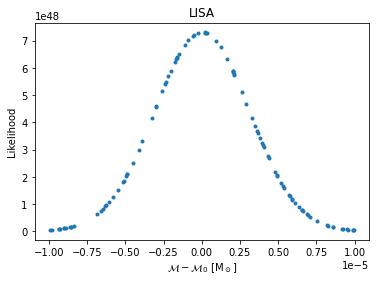

In [15]:
# this is q 
plt.plot(xs, jnp.exp(lls), ".")
plt.xlabel(r"$\mathcal{M} - \mathcal{M}_0$ [M$_\odot$]")
plt.ylabel("Likelihood")
plt.title(detector)

Text(0.5, 1.0, 'LISA')

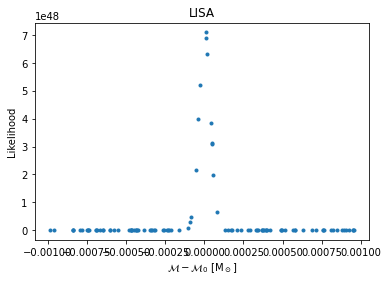

In [21]:
plt.plot(xs, jnp.exp(lls), ".")
plt.xlabel(r"$\mathcal{M} - \mathcal{M}_0$ [M$_\odot$]")
plt.ylabel("Likelihood")
plt.title(detector)

Text(0.5, 1.0, 'LISA')

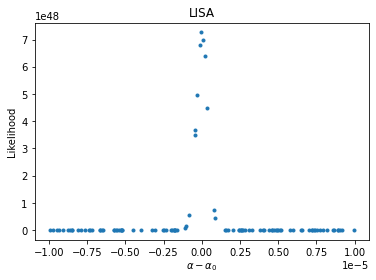

In [30]:
plt.plot(xs, jnp.exp(lls), ".")
plt.xlabel(r"$\alpha - \alpha_0$")
plt.ylabel("Likelihood")
plt.title(detector)

Text(0.5, 1.0, 'LISA')

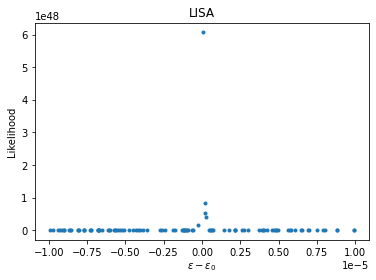

In [35]:
plt.plot(xs, jnp.exp(lls), ".")
plt.xlabel(r"$\epsilon - \epsilon_0$")
plt.ylabel("Likelihood")
plt.title(detector)

# 2D

In [112]:
if detector == "LISA":

    def ptform_log(u):
        assert u.shape == (4,)
        v_m = np.array([6, 4, 4, 5])#, 1e-5])
        s = np.sign(u - 0.5)
        return s * 10**(-8 + v_m * (u))


def unpack(x: jnp.ndarray) -> GravAtom:
    """
    Convenience function to unpack parameters into an accretion disk.
    """
    dMc_MSUN = x[0]
    
    dalph = x[1]
    deps = x[2]
    dq = x[3]
    Mc = GA_D.M_chirp + dMc_MSUN * MSUN
    alph = GA_D.alpha + dalph
    eps = GA_D.epsilon_init + deps
    q = GA_D.q * 10**dq
    m_1 = get_m_1(Mc, q)
    f_c = get_f_isco(m_1)
    return GravAtom(
        alph, eps, Mc, q, GA_D.Phi_c, GA_D.tT_c, GA_D.dL, f_c
    )


#@jax.jit
def get_ll_fft(x: jnp.ndarray) -> jnp.ndarray:
    """
    Likelihood function
    """
    ga_h = unpack(x)
   # print(ga_h)
    #print(loglikelihood_fft(ga_h, GA_D, FS, PAD_LOW, PAD_HIGH, S_n))
    return loglikelihood_fft(ga_h, GA_D, FS, PAD_LOW, PAD_HIGH, S_n)




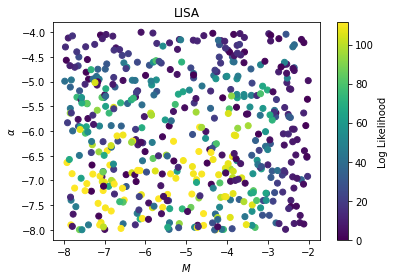

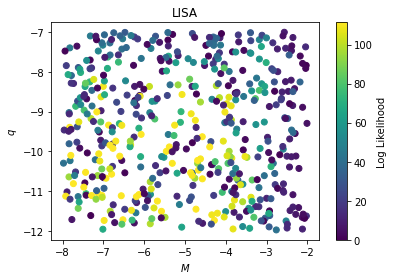

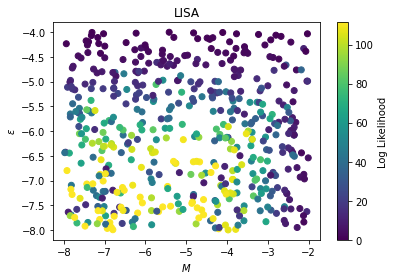

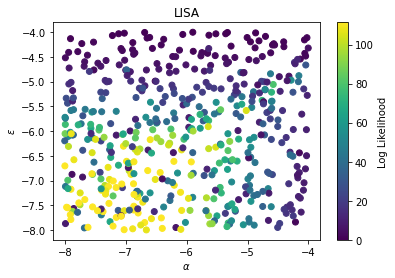

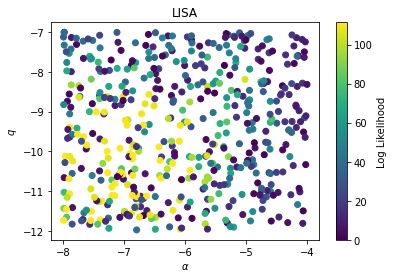

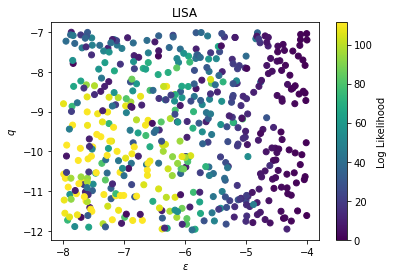

In [225]:
# 4D 
# Sample points and compute likelihood
#xs = []
#lls = []

#for _ in trange(500):
 #   xs.append(ptform_log_new(np.random.rand(4)))
  #  lls.append(get_ll_fft(xs[-1]))

#xs = jnp.array(xs)
#lls = jnp.array(lls)
m_samples = []
a_samples = []
eps_samples = []
q_samples = []
for i in range(len(xs)):
    m_samples.append(np.log10(abs(xs[i][0])))
    a_samples.append(np.log10(abs(xs[i][1])))
    eps_samples.append(np.log10(abs(xs[i][2])))
    q_samples.append(np.log10(abs(xs[i][3])))
# Plot
plt.scatter(m_samples, a_samples, c=lls-lls.min())

plt.xlabel(r"$M$")

plt.ylabel(r"$\alpha$")
plt.colorbar(label="Log Likelihood")
plt.title(detector)
plt.show()

plt.scatter(m_samples, q_samples, c=lls-lls.min())

plt.xlabel(r"$M$")

plt.ylabel(r"$q$")
plt.colorbar(label="Log Likelihood")
plt.title(detector)
plt.show()

plt.scatter(m_samples, eps_samples, c=lls-lls.min())

plt.xlabel(r"$M$")

plt.ylabel(r"$\epsilon$")
plt.colorbar(label="Log Likelihood")
plt.title(detector)
plt.show()

plt.scatter(a_samples, eps_samples, c=lls-lls.min())

plt.xlabel(r"$\alpha$")

plt.ylabel(r"$\epsilon$")
plt.colorbar(label="Log Likelihood")
plt.title(detector)
plt.show()

plt.scatter(a_samples, q_samples, c=lls-lls.min())

plt.xlabel(r"$\alpha$")

plt.ylabel(r"$q$")
plt.colorbar(label="Log Likelihood")
plt.title(detector)
plt.show()

plt.scatter(eps_samples, q_samples, c=lls-lls.min())

plt.xlabel(r"$\epsilon$")

plt.ylabel(r"$q$")
plt.colorbar(label="Log Likelihood")
plt.title(detector)
plt.show()

In [209]:
lls.max()

DeviceArray(112.50736285, dtype=float64)

In [210]:
a_samples_pos = []
m_samples_pos = []
eps_samples_pos = []
q_samples_pos = []
for i in range(len(a_samples)):
    a_samples_pos.append(abs(a_samples[i]))
    m_samples_pos.append(abs(m_samples[i]))
    eps_samples_pos.append(abs(eps_samples[i]))
    q_samples_pos.append(abs(q_samples[i]))

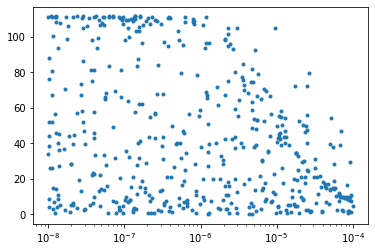

In [211]:
plt.semilogx(a_samples_pos,lls-lls.min(), ".")


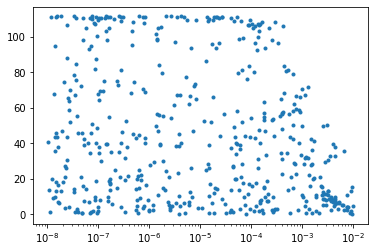

In [212]:
plt.semilogx(m_samples_pos,lls-lls.min(), ".")

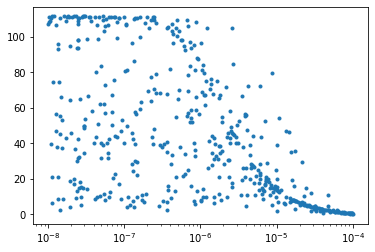

In [213]:
plt.semilogx(eps_samples_pos,lls-lls.min(), ".")

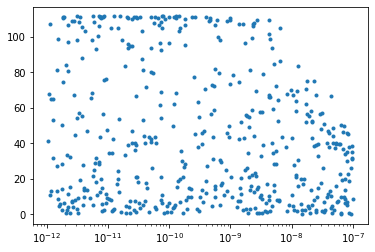

In [214]:
plt.semilogx(q_samples_pos,lls-lls.min(), ".")

In [21]:
#v_m = np.array([1e-2, 5e-5, 1e-4, 1e-3])
# Use 500 - 2000 live points. You need a lot, otherwise you may miss the
# high-likelihood region!
sampler = dynesty.NestedSampler(get_ll_fft, ptform_log, 4, nlive=1000, bound = 'single')
sampler.run_nested(dlogz = 10)
results_4d_log_snr15 = sampler.results

2179it [1:11:08,  1.96s/it, +1000 | bound: 0 | nc: 1 | ncall: 10026 | eff(%): 35.220 | loglstar:   -inf < 112.504 <    inf | logz: 109.226 +/-    nan | dlogz:  0.003 > 10.000]


In [113]:
#v_m = np.array([1e-2, 5e-5, 1e-4, 1e-3])
# Use 500 - 2000 live points. You need a lot, otherwise you may miss the
# high-likelihood region!
sampler = dynesty.NestedSampler(get_ll_fft, ptform_log, 4, nlive=1000, bound = 'single')
sampler.run_nested(dlogz = 1)
results_4d_log_snr15_lowz = sampler.results

3577it [5:43:15,  5.76s/it, +1000 | bound: 2 | nc: 1 | ncall: 37105 | eff(%): 12.677 | loglstar:   -inf < 112.509 <    inf | logz: 109.279 +/-  0.029 | dlogz:  0.001 >  1.000]


Quantiles:
$\mathcal{M} - \mathcal{M}_0$ [M$_\odot$] [(0.025, -7.546157779824091e-06), (0.5, -5.64368405930507e-08), (0.975, 0.0001059596422668035)]
Quantiles:
$\epsilon_{init} - \epsilon_{init,0}$ [(0.025, -5.949509939841553e-07), (0.5, -4.987799183611487e-08), (0.975, 1.6884201720890783e-06)]
Quantiles:
$\alpha - \alpha_{0}$ [(0.025, -5.731712709352473e-07), (0.5, -3.8570616260597804e-08), (0.975, -1.0838515975853082e-08)]
Quantiles:
$\log_{10}(q/q_0)$ [(0.025, -2.5781597650003047e-06), (0.5, -9.613279043613414e-08), (0.975, 6.42858138220148e-06)]


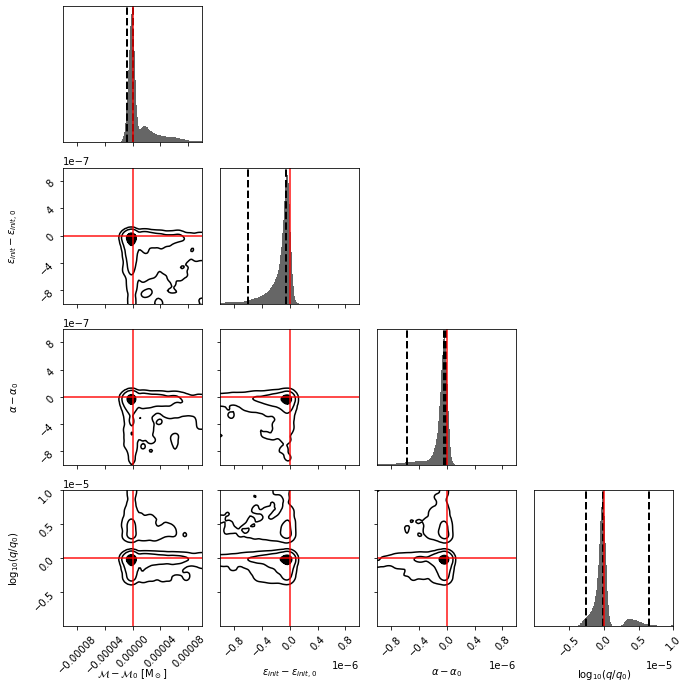

In [115]:
labels = (
    r"$\mathcal{M} - \mathcal{M}_0$ [M$_\odot$]",
    r"$\epsilon_{init} - \epsilon_{init,0}$",
    r"$\alpha - \alpha_{0}$",r"$\log_{10}(q/q_0)$"
)
# 
quantiles_2d = [1 - np.exp(-(x ** 2) / 2) for x in [1, 2, 3]]
fig, axes = dyplot.cornerplot(
    results_4d_log_snr15_lowz, labels=labels, quantiles_2d=quantiles_2d, truths=(0, 0, 0, 0), verbose = True, span = [(-1e-4,1e-4),(-1e-6,1e-6),(-1e-6,1e-6),(-1e-5,1e-5)]
)
fig.tight_layout()

Quantiles:
$\mathcal{M} - \mathcal{M}_0$ [M$_\odot$] [(0.025, -7.141342715095902e-06), (0.5, -8.158502150059679e-08), (0.975, 8.659204062409049e-05)]
Quantiles:
$\epsilon_{init} - \epsilon_{init,0}$ [(0.025, -6.239292711876974e-07), (0.5, -4.910358179680676e-08), (0.975, 1.7496058783459324e-06)]
Quantiles:
$\alpha - \alpha_{0}$ [(0.025, -5.967052037062558e-07), (0.5, -3.9644117384860856e-08), (0.975, -1.0447412083454209e-08)]
Quantiles:
$q$ [(0.025, -2.3663338882846346e-06), (0.5, -8.526607707108243e-08), (0.975, 6.841314114101731e-06)]


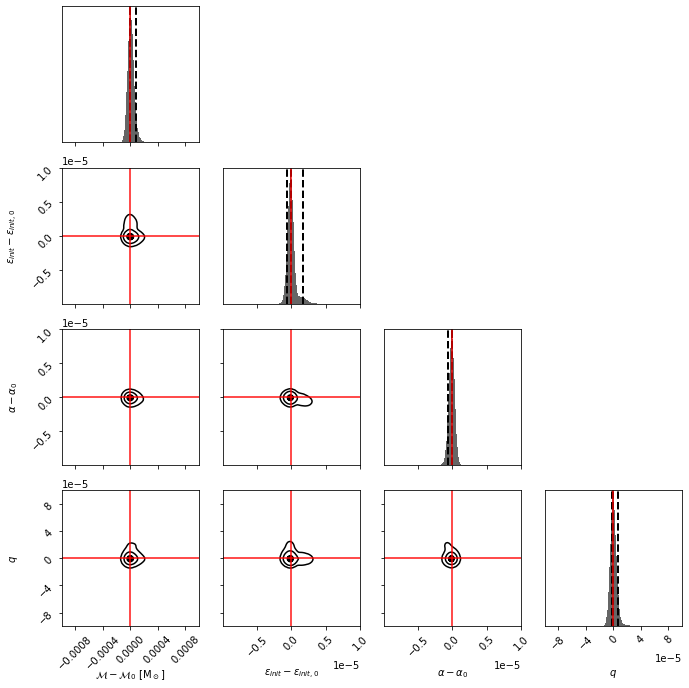

In [26]:
# Plot 500 live points,     def ptform(u):
     #   assert u.shape == (3,)
      #  v_m = np.array([1e-3, 1e-6, 1e-4])
       # return 2 * v_m * (u - 0.5)
labels = (
    r"$\mathcal{M} - \mathcal{M}_0$ [M$_\odot$]",
    r"$\epsilon_{init} - \epsilon_{init,0}$",
    r"$\alpha - \alpha_{0}$",r"$q$"
)
# 
quantiles_2d = [1 - np.exp(-(x ** 2) / 2) for x in [1, 2, 3]]
fig, axes = dyplot.cornerplot(
    results_4d_log_snr15, labels=labels, quantiles_2d=quantiles_2d, truths=(0, 0, 0, 0), verbose = True, span = [(-1e-3,1e-3),(-1e-5,1e-5),(-1e-5,1e-5),(-1e-4,1e-4)]
)
fig.tight_layout()
fig.savefig('results_4d_logp_snr15.pdf')

In [25]:
with open(f"ga-4d-log-snr-15.pkl", "wb") as output:
    pickle.dump(results_4d_log_snr15,output, pickle.HIGHEST_PROTOCOL)

Quantiles:
$\mathcal{M} - \mathcal{M}_0$ [M$_\odot$] [(0.025, -7.141342715095902e-06), (0.5, -8.158502150059679e-08), (0.975, 8.659204062409049e-05)]
Quantiles:
$\epsilon_{init} - \epsilon_{init,0}$ [(0.025, -6.239292711876974e-07), (0.5, -4.910358179680676e-08), (0.975, 1.7496058783459324e-06)]
Quantiles:
$\alpha - \alpha_{0}$ [(0.025, -5.967052037062558e-07), (0.5, -3.9644117384860856e-08), (0.975, -1.0447412083454209e-08)]
Quantiles:
$\log_{10}(q/q_0)$ [(0.025, -2.3663338882846346e-06), (0.5, -8.526607707108243e-08), (0.975, 6.841314114101731e-06)]


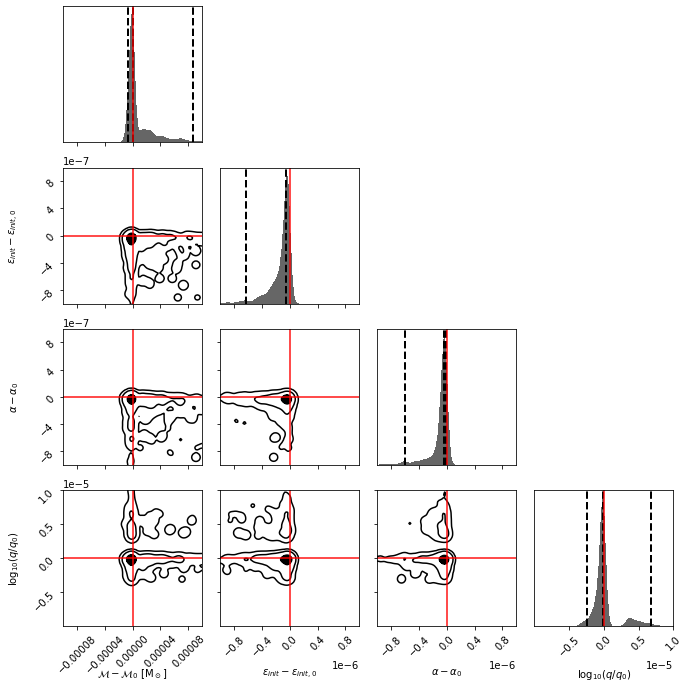

In [104]:
# Plot 500 live points,     def ptform(u):
     #   assert u.shape == (3,)
      #  v_m = np.array([1e-3, 1e-6, 1e-4])
       # return 2 * v_m * (u - 0.5)
labels = (
    r"$\mathcal{M} - \mathcal{M}_0$ [M$_\odot$]",
    r"$\epsilon_{init} - \epsilon_{init,0}$",
    r"$\alpha - \alpha_{0}$",r"$\log_{10}(q/q_0)$"
)
# 
quantiles_2d = [1 - np.exp(-(x ** 2) / 2) for x in [1, 2, 3]]
quantiles = [1 - np.exp(-(x ** 2) / 2) for x in [1, 2, 3]]
fig, axes = dyplot.cornerplot(
    results_4d_log_snr15, labels=labels, quantiles_2d=quantiles_2d, truths=(0, 0, 0, 0), verbose = True, span = [(-1e-4,1e-4),(-1e-6,1e-6),(-1e-6,1e-6),(-1e-5,1e-5)]
)
fig.tight_layout()
fig.savefig('ga_4d_logp_zoom.pdf')

In [184]:
from dynesty import utils as dyfunc
rlist = []
rlist.append(results_4d_log_snr15)
rlist.append(results_4d_log_snr15_lowz)

# Merge into a single run.
results_combine = dyfunc.merge_runs(rlist)

Quantiles:
$\mathcal{M} - \mathcal{M}_0$ [M$_\odot$] [(0.025, -7.45344899096031e-06), (0.5, -6.442135922596198e-08), (0.975, 9.788312166284661e-05)]
Quantiles:
$\epsilon_{init} - \epsilon_{init,0}$ [(0.025, -6.001585579720453e-07), (0.5, -4.9814023465843626e-08), (0.975, 1.708710858800233e-06)]
Quantiles:
$\alpha - \alpha_{0}$ [(0.025, -5.810469045017942e-07), (0.5, -3.909939749923954e-08), (0.975, -1.0729511606025724e-08)]
Quantiles:
$\log_{10}(q/q_0)$ [(0.025, -2.5341827020702147e-06), (0.5, -9.239366223350146e-08), (0.975, 6.601604007523282e-06)]


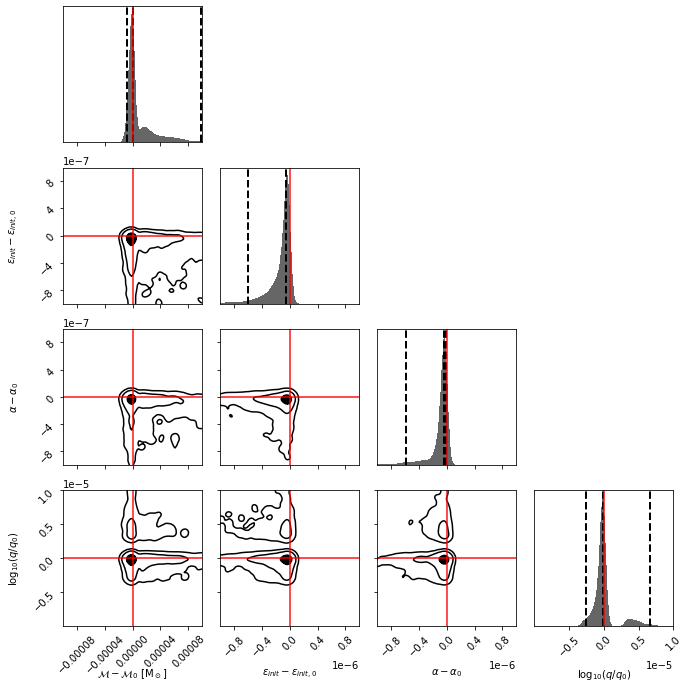

In [185]:
# Plot 500 live points,     def ptform(u):
     #   assert u.shape == (3,)
      #  v_m = np.array([1e-3, 1e-6, 1e-4])
       # return 2 * v_m * (u - 0.5)
labels = (
    r"$\mathcal{M} - \mathcal{M}_0$ [M$_\odot$]",
    r"$\epsilon_{init} - \epsilon_{init,0}$",
    r"$\alpha - \alpha_{0}$",r"$\log_{10}(q/q_0)$"
)
# 
quantiles_2d = [1 - np.exp(-(x ** 2) / 2) for x in [1, 2, 3]]
quantiles = [1 - np.exp(-(x ** 2) / 2) for x in [1, 2, 3]]
fig, axes = dyplot.cornerplot(
    results_combine, labels=labels, quantiles_2d=quantiles_2d, truths=(0, 0, 0, 0), verbose = True, span = [(-1e-4,1e-4),(-1e-6,1e-6),(-1e-6,1e-6),(-1e-5,1e-5)]
)
fig.tight_layout()

In [215]:
if detector == "LISA":

#    def ptform_log_3d(u):
#        assert u.shape == (3,)
#        v_m = np.array([4, 4, 5])#, 6, 1e-5])
#        s = np.sign(u - 0.5)
#        return s * 10**(-8 + v_m * (u))
    
    def ptform_log_new(u):
        assert u.shape == (4,)
        v_m = np.array([6, 4, 4, 5])# 3])
        s = np.sign(np.random.rand(4) - 0.5)
        res = [s[0]* 10**(-8 + v_m[0] * (u[0])),s[1]* 10**(-8 + v_m[1] * (u[1])),s[2]* 10**(-8 + v_m[2] * (u[2])),s[3]* 10**(-12 + v_m[3] * (u[3]))]
        return res


def unpack(x: jnp.ndarray) -> GravAtom:
    """
    Convenience function to unpack parameters into an accretion disk.
    """
    dMc_MSUN = x[0]
    
    dalph = x[1]
    deps = x[2]
    dq = x[3]
    Mc = GA_D.M_chirp + dMc_MSUN * MSUN
    alph = GA_D.alpha + dalph
    eps = GA_D.epsilon_init + deps
    q = GA_D.q + dq
    m_1 = get_m_1(Mc, q)
    f_c = get_f_isco(m_1)
    return GravAtom(
        alph, eps, Mc, q, GA_D.Phi_c, GA_D.tT_c, GA_D.dL, f_c
    )


#@jax.jit
def get_ll_fft(x: jnp.ndarray) -> jnp.ndarray:
    """
    Likelihood function
    """
    ga_h = unpack(x)
   # print(ga_h)
    #print(loglikelihood_fft(ga_h, GA_D, FS, PAD_LOW, PAD_HIGH, S_n))
    return loglikelihood_fft(ga_h, GA_D, FS, PAD_LOW, PAD_HIGH, S_n)

In [216]:
sampler = dynesty.NestedSampler(get_ll_fft, ptform_log_new, 4, nlive=1000, bound = 'single')
sampler.run_nested()
results_4d_log_new = sampler.results

3495it [5:08:25,  5.29s/it, +1000 | bound: 0 | nc: 1 | ncall: 34676 | eff(%): 13.348 | loglstar:   -inf < 112.507 <    inf | logz: 109.398 +/-  0.020 | dlogz:  0.001 >  1.009]


Quantiles:
$\mathcal{M} - \mathcal{M}_0$ [M$_\odot$] [(0.025, -5.753237315048269e-05), (0.5, -1.1946125252885308e-08), (0.975, 4.799397765224224e-05)]
Quantiles:
$\epsilon_{init} - \epsilon_{init,0}$ [(0.025, -8.95059560066062e-07), (0.5, -1.0124251207878155e-08), (0.975, 1.0849546433737769e-06)]
Quantiles:
$\alpha - \alpha_{0}$ [(0.025, -3.112487985774818e-07), (0.5, -1.070012262141388e-08), (0.975, 2.824240671430281e-07)]
Quantiles:
$q$ [(0.025, -9.571488281705965e-10), (0.5, 1.1459510792245265e-12), (0.975, 8.958227574126725e-10)]


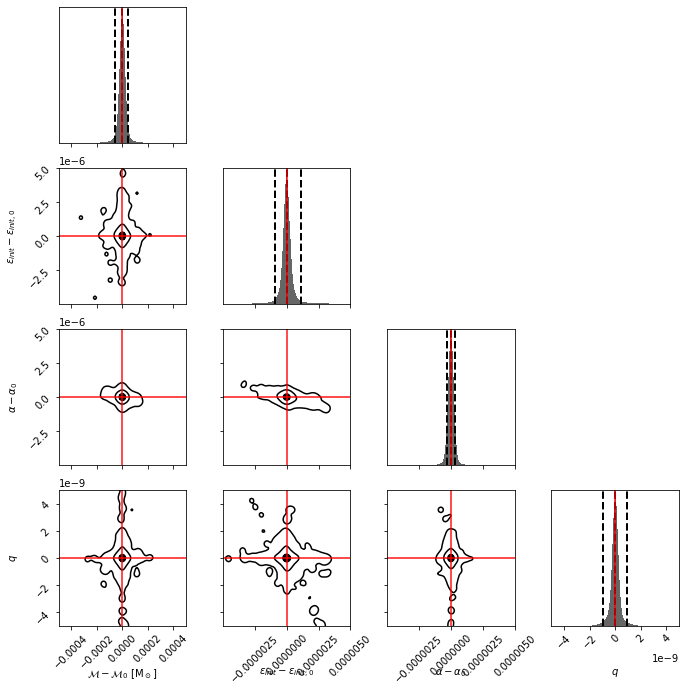

In [227]:
labels = (
    r"$\mathcal{M} - \mathcal{M}_0$ [M$_\odot$]",
    r"$\epsilon_{init} - \epsilon_{init,0}$",
    r"$\alpha - \alpha_{0}$",r"$q$",
)
# 
quantiles_2d = [1 - np.exp(-(x ** 2) / 2) for x in [1, 2, 3]]
quantiles = [1 - np.exp(-(x ** 2) / 2) for x in [1, 2, 3]]
fig, axes = dyplot.cornerplot(
    results_4d_log_new, labels=labels, quantiles_2d=quantiles_2d, truths=(0, 0, 0,0), verbose = True, span = [(-5e-4,5e-4),(-5e-6,5e-6),(-5e-6,5e-6),(-5e-9,5e-9)]
)
fig.tight_layout()
fig.savefig('ga_4d_log_new.pdf')

In [229]:
lls.max()

DeviceArray(112.50736285, dtype=float64)

In [228]:
with open(f"ga-4d-log-new.pkl", "wb") as output:
    pickle.dump(results_4d_log_new,output, pickle.HIGHEST_PROTOCOL)

In [187]:
sampler = dynesty.NestedSampler(get_ll_fft, ptform_log_3d, 3, nlive=1000, bound = 'single')
sampler.run_nested()
results_3d_log = sampler.results

3177it [3:15:41,  3.70s/it, +1000 | bound: 0 | nc: 1 | ncall: 22179 | eff(%): 19.722 | loglstar:   -inf < 112.503 <    inf | logz: 109.703 +/-  0.008 | dlogz:  0.001 >  1.009]


Quantiles:
$\mathcal{M} - \mathcal{M}_0$ [M$_\odot$] [(0.025, -7.249000404694708e-06), (0.5, -7.812314227627751e-08), (0.975, 9.299017176652027e-05)]
Quantiles:
$\epsilon_{init} - \epsilon_{init,0}$ [(0.025, -5.923623868763109e-07), (0.5, -5.004891422311031e-08), (0.975, 1.6055381174293466e-06)]
Quantiles:
$\alpha - \alpha_{0}$ [(0.025, -5.085447326332555e-07), (0.5, -3.7176306728282104e-08), (0.975, -1.0602056087021994e-08)]


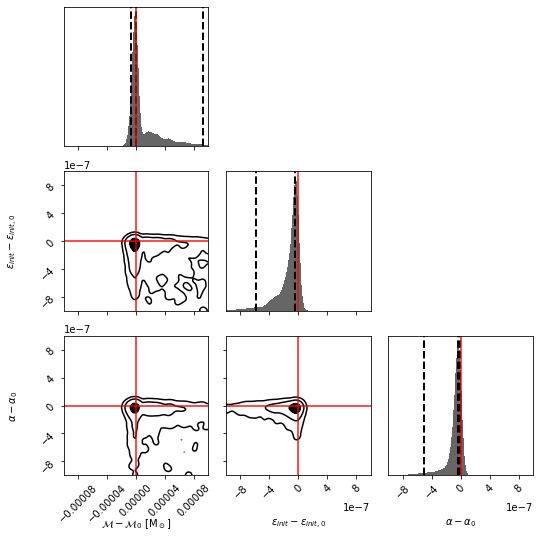

In [188]:
# Plot 500 live points,     def ptform(u):
     #   assert u.shape == (3,)
      #  v_m = np.array([1e-3, 1e-6, 1e-4])
       # return 2 * v_m * (u - 0.5)
labels = (
    r"$\mathcal{M} - \mathcal{M}_0$ [M$_\odot$]",
    r"$\epsilon_{init} - \epsilon_{init,0}$",
    r"$\alpha - \alpha_{0}$",
)
# 
quantiles_2d = [1 - np.exp(-(x ** 2) / 2) for x in [1, 2, 3]]
quantiles = [1 - np.exp(-(x ** 2) / 2) for x in [1, 2, 3]]
fig, axes = dyplot.cornerplot(
    results_3d_log, labels=labels, quantiles_2d=quantiles_2d, truths=(0, 0, 0), verbose = True, span = [(-1e-4,1e-4),(-1e-6,1e-6),(-1e-6,1e-6)]
)
fig.tight_layout()

In [192]:
sampler = dynesty.NestedSampler(get_ll_fft, ptform_log_3d, 3, nlive=1000, bound = 'single')
sampler.run_nested()
results_3d_log_fixmass = sampler.results

3308it [6:34:08,  7.15s/it, +1000 | bound: 0 | nc: 1 | ncall: 29175 | eff(%): 15.290 | loglstar:   -inf < 112.496 <    inf | logz: 109.533 +/-  0.024 | dlogz:  0.001 >  1.009]


Quantiles:
$\mathcal{M} - \mathcal{M}_0$ [M$_\odot$] [(0.025, -5.071175289201867e-07), (0.5, -5.068359569515339e-08), (0.975, 1.5310858341949314e-06)]
Quantiles:
$\epsilon_{init} - \epsilon_{init,0}$ [(0.025, -4.806584228553067e-07), (0.5, -3.296913347173002e-08), (0.975, -1.0667919251908713e-08)]
Quantiles:
$\alpha - \alpha_{0}$ [(0.025, -2.269515935753364e-06), (0.5, -8.934956001520987e-08), (0.975, 6.8250206517221e-06)]


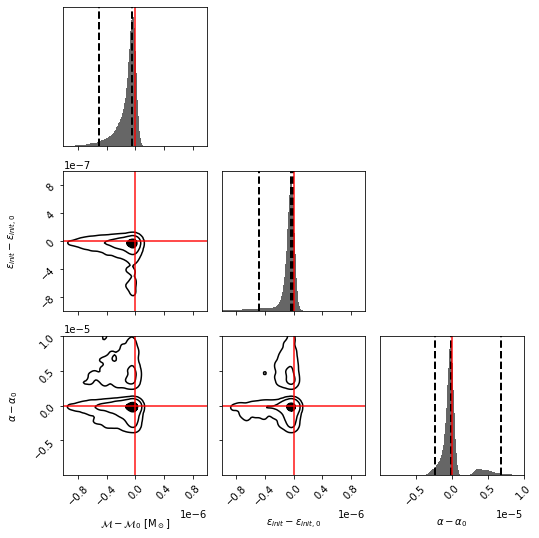

In [194]:
# Plot 500 live points,     def ptform(u):
     #   assert u.shape == (3,)
      #  v_m = np.array([1e-3, 1e-6, 1e-4])
       # return 2 * v_m * (u - 0.5)
labels = (
    r"$\mathcal{M} - \mathcal{M}_0$ [M$_\odot$]",
    r"$\epsilon_{init} - \epsilon_{init,0}$",
    r"$\alpha - \alpha_{0}$",
)
# 
quantiles_2d = [1 - np.exp(-(x ** 2) / 2) for x in [1, 2, 3]]
quantiles = [1 - np.exp(-(x ** 2) / 2) for x in [1, 2, 3]]
fig, axes = dyplot.cornerplot(
    results_3d_log_fixmass, labels=labels, quantiles_2d=quantiles_2d, truths=(0, 0, 0), verbose = True, span = [(-1e-6,1e-6),(-1e-6,1e-6),(-1e-5,1e-5)]
)
fig.tight_layout()

In [58]:
lls.max()

DeviceArray(11248.93352451, dtype=float64)

In [54]:
dg = make_grav_atom(m1, m2, alpha, eps_init, Phi_c, t_c, dL)
dg2 = make_grav_atom(get_m_1(get_M_chirp(m1,m2)+1e-1 * MSUN,GA_D.q*10**1e-2), get_m_2(get_M_chirp(m1,m2)+1e-1 * MSUN,GA_D.q*10**1e-2), 0.2+1e-4, 1e-2+1e-4, Phi_c, t_c, dL)


In [165]:
x=1.0001
y = 1.001
m = 1.00001
r = 1.001
dgx = make_grav_atom(m1, m2, alpha*x, eps_init, Phi_c, t_c, dL)
dgnew = GravAtom(alpha=0.20000006214179653, epsilon_init=0.010000034631927385, M_chirp=7.916402000064858e+32, q=0.00010000000604484788, Phi_c=np.array(0.), tT_c=np.array(0.), dL=1.3394915721889272e+25, f_c=0.04397009894077899)
dgreal = make_grav_atom(get_m_1(7.916401791288136e+32 ,0.00010000000077784311 ),get_m_2(7.916401791288136e+32 ,0.00010000000077784311 ),0.19999996845011964, 0.009999912527675089, Phi_c, t_c, 1.3394915721889272e+25)
dgy = make_grav_atom(m1, m2, alpha, eps_init*y, Phi_c, t_c, dL)
dgm = make_grav_atom(get_m_1(get_M_chirp(m1,m2)*m,GA_D.q), get_m_2(get_M_chirp(m1,m2)*m ,GA_D.q ), alpha, eps_init, Phi_c, t_c, dL)
dgr = make_grav_atom(get_m_1(get_M_chirp(m1,m2),GA_D.q * r), get_m_2(get_M_chirp(m1,m2) ,GA_D.q * r), alpha, eps_init, Phi_c, t_c, dL)

In [124]:
((get_M_chirp(m1,m2)*m)-get_M_chirp(m1,m2))/MSUN

0.003980992088939743

In [125]:
alpha*x #2e-5

0.20002

In [126]:
eps_init*y #1e-5

0.01001

In [173]:
dg

GravAtom(alpha=0.2, epsilon_init=0.01, M_chirp=7.91640181833791e+32, q=9.999999999999999e-05, Phi_c=0.0, tT_c=1.0292712505433908e+16, dL=3.08567758149137e+24, f_c=0.04397009835544326)

In [232]:
loglikelihood_fft(GA_D,GA_D, FS, PAD_LOW, PAD_HIGH, S_n)-lls.max()

DeviceArray(9.9781855e-05, dtype=float64)

In [175]:
print(loglikelihood_fft(GA_D,GA_D, FS, PAD_LOW, PAD_HIGH, S_n))
print(loglikelihood_fft(dgx, dg, FS, PAD_LOW, PAD_HIGH, S_n))
print(loglikelihood_fft(dgy, dg, FS, PAD_LOW, PAD_HIGH, S_n))
print(loglikelihood_fft(dgm, dg, FS, PAD_LOW, PAD_HIGH, S_n))
print(loglikelihood_fft(dgr, dg, FS, PAD_LOW, PAD_HIGH, S_n))
print(loglikelihood_fft(dgreal, dg, FS, PAD_LOW, PAD_HIGH, S_n))
print(loglikelihood_fft(dgnew, GA_D, FS, PAD_LOW, PAD_HIGH, S_n))

11251.492501308125
61854.38168604837
28151.379251004273
18519.115187157302
60209.274039167976
197844.26787391206
11220.781400541618


In [181]:
print(loglikelihood_fft(GA_D2, GA_D, FS, PAD_LOW, PAD_HIGH, S_n))

70.57468832278704


In [179]:
def get_signal_system() -> Tuple[GravAtom, Tuple[float, float]]:
    """
    Creates a gravitational atom with correct SNR for given detector.
    
    Returns:
        The dark dress and frequency range corresponding to an observing time
        of ``T_OBS`` before coalescence.
    """
    M_1 = np.array(1e5 * MSUN)
    M_2 = np.array(M_1 * 1e-4 * 10**(0.1*1e-5))
    M_CHIRP = get_M_chirp(M_1, M_2)
    Q = M_2 / M_1
    alph = 0.2
    eps_init = 1e-2
    TT_C = np.array(0.0)
    F_C = get_f_isco(M_1)
    PHI_C = np.array(0.0)
    _GA_D = GravAtom(
        alph,
        eps_init,
        get_M_chirp(M_1, M_2),
        M_2 / M_1,
        PHI_C,
        tT_c=TT_C,
        dL=np.array(100e6 * PC),
        f_c=get_f_isco(M_1),
    )

    ftest = lambda f_l: (t_to_c(f_l, _GA_D) - T_OBS)**2
    res = minimize_scalar(ftest, bracket=(2e-3,2e-2))
    if not res.success:
        raise RuntimeError(f"finding f_l failed: {res}")
    f_ltest = res.x
    print(f_ltest)
    
    ftest = lambda f_l: (t_to_c(f_l, _GA_D) - _GA_D.tT_c)**2
    res = minimize_scalar(ftest, bracket=(4e-2,4.4e-2), bounds=(4e-2,4.4e-2), method='bounded')
    if not res.success:
        raise RuntimeError(f"finding f_l failed: {res}")
    f_htest = res.x
    print(f_htest)
    
    print(t_to_c(f_htest,_GA_D))

    
    # Frequency range and grids
 #   F_RANGE_D = get_f_range(_GA_D, T_OBS, bracket = (2e-3,2e-2))
    F_RANGE_D2 = f_ltest, f_htest
    FS = np.linspace(
        max(f_ltest, f_range_n[0]), min(f_htest, f_range_n[1]), 50_000
    )
 #   print(F_RANGE_D)
  #  print(calculate_SNR(_GA_D,FS,S_n))

    # Get dL
    _fn = lambda dL: calculate_SNR(
            GravAtom(
                _GA_D.alpha,
                _GA_D.epsilon_init,
                _GA_D.M_chirp,
                _GA_D.q,
                _GA_D.Phi_c,
                _GA_D.tT_c,
                dL,
                _GA_D.f_c,
            ),
            FS,
            S_n,
        )
    
    print(_fn(100000e6))
    res = root_scalar(
        lambda dL: (_fn(dL) - SNR_THRESH), bracket=(0.1e6 * PC, 100000e8 * PC)
    )
    assert res.converged
    DL = res.root

    # Signal system
    GA_D2 = GravAtom(
        _GA_D.alpha,
        _GA_D.epsilon_init,
        _GA_D.M_chirp,
        _GA_D.q,
        _GA_D.Phi_c,
        _GA_D.tT_c,
        DL,
        _GA_D.f_c,
    )

    return GA_D2, F_RANGE_D2

In [180]:
GA_D2, F_RANGE_D2 = get_signal_system()

# FS = jnp.linspace(*F_RANGE_D, 10_000)  # coarse grid
FS2 = np.linspace(*F_RANGE_D2, 100_000)  # finer grid
PAD_LOW, PAD_HIGH = get_match_pads(FS2)  # padding for likelihood calculation

0.0029484850909868177
0.04396911887443054
7.249902248382568
2.0092401125491764e+16


In [135]:
GA_D.q * 10**1e-5

0.00010000230261160267

# 3D - NS

In [87]:
def ptform(u):
        assert u.shape == (3,)
        v_m = np.array([1e-3, 1e-6, 1e-4])
        return 2 * v_m * (u - 0.5)


def unpack(x: jnp.ndarray) -> GravAtom:
    """
    Convenience function to unpack parameters into an accretion disk.
    """
    dMc_MSUN = x[0]
    deps = x[1]
    dalph = x[2]
    Mc = GA_D.M_chirp + dMc_MSUN * MSUN
    alph = GA_D.alpha + dalph
    eps = GA_D.epsilon_init + deps
    m_1 = get_m_1(Mc, GA_D.q)
    f_c = get_f_isco(m_1)
    return GravAtom(
        alph, eps, Mc, GA_D.q, GA_D.Phi_c, GA_D.tT_c, GA_D.dL, f_c
    )


#@jax.jit
def get_ll_fft(x: jnp.ndarray) -> jnp.ndarray:
    """
    Likelihood function
    """
    ga_h = unpack(x)
    return loglikelihood_fft(ga_h, GA_D, FS, PAD_LOW, PAD_HIGH, S_n)




In [89]:
# Use 500 - 2000 live points. You need a lot, otherwise you may miss the
# high-likelihood region!
sampler = dynesty.NestedSampler(get_ll_fft, ptform, 3, nlive=500)
sampler.run_nested()
results = sampler.results

805it [15:37,  2.38s/it, bound: 0 | nc: 9 | ncall: 2585 | eff(%): 31.141 | loglstar:   -inf <  0.319 <    inf | logz: -0.097 +/-  0.030 | dlogz: 103.816 >  0.509] Traceback (most recent call last):
  File "/Users/Pippa/opt/anaconda3/envs/pippa/lib/python3.7/site-packages/dynesty/dynesty.py", line 982, in __call__
    return self.func(x, *self.args, **self.kwargs)
  File "<ipython-input-87-5e0905c39fb9>", line 30, in get_ll_fft
    return loglikelihood_fft(ga_h, GA_D, FS, PAD_LOW, PAD_HIGH, S_n)
  File "/Users/Pippa/Documents/Amsterdam/Spikes/dec-pydd-main-2/src/pydd/analysis.py", line 129, in loglikelihood_fft
    ip_hd = calculate_match_unnormd_fft(params_h, params_d, fs, pad_low, pad_high, S_n)
  File "/Users/Pippa/Documents/Amsterdam/Spikes/dec-pydd-main-2/src/pydd/analysis.py", line 106, in calculate_match_unnormd_fft
    wf_h = amp(fs, params_h) * jnp.exp(1j * Psi(fs, params_h))
  File "/Users/Pippa/Documents/Amsterdam/Spikes/dec-pydd-main-2/src/pydd/binary.py", line 194, in Psi
 

Exception while calling loglikelihood function:
  params: [-8.79142987e-04  9.40080764e-07 -3.08026400e-05]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

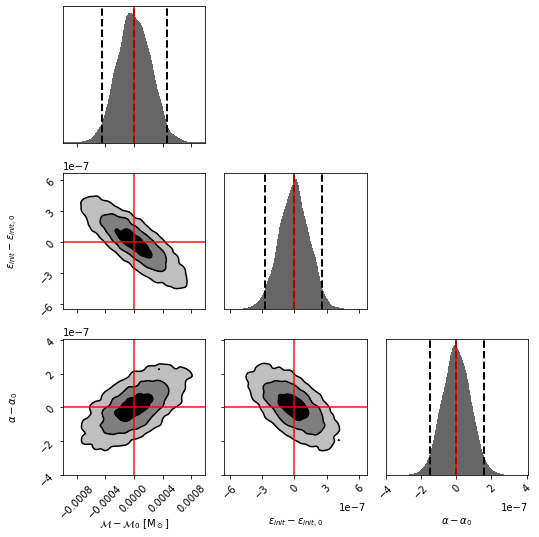

In [117]:
# Plot 500 live points,     def ptform(u):
     #   assert u.shape == (3,)
      #  v_m = np.array([1e-3, 1e-6, 1e-4])
       # return 2 * v_m * (u - 0.5)
labels = (
    r"$\mathcal{M} - \mathcal{M}_0$ [M$_\odot$]",
    r"$\epsilon_{init} - \epsilon_{init,0}$",
    r"$\alpha - \alpha_{0}$",
)
# 
quantiles_2d = [1 - np.exp(-(x ** 2) / 2) for x in [1, 2, 3]]
fig, axes = dyplot.cornerplot(
    results, labels=labels, quantiles_2d=quantiles_2d, truths=(0, 0, 0), span = [()]
)
fig.tight_layout()

# 4D NS 

In [52]:
def ptform(u):
        assert u.shape == (3,)
        #v_m = np.array([1e-2, 1e-6, 1e-3, 1e-4])
        v_m = np.array([1e-3, 1e-4, 1e-3])#, 1e-1])
        return 2 * v_m * (u - 0.5)


def unpack(x: jnp.ndarray) -> GravAtom:
    """
    Convenience function to unpack parameters into an accretion disk.
    """
    dMc_MSUN = x[0]
    deps = x[1]
    dalph = x[2]
  #  dq = x[3]
    Mc = GA_D.M_chirp + dMc_MSUN * MSUN
    alph = GA_D.alpha + dalph
    eps = GA_D.epsilon_init + deps
    q = GA_D.q #* 10**dq
    m_1 = get_m_1(Mc, q)
    f_c = get_f_isco(m_1)
    return GravAtom(
        alph, eps, Mc, q, GA_D.Phi_c, GA_D.tT_c, GA_D.dL, f_c
    )


#@jax.jit
def get_ll_fft(x: jnp.ndarray) -> jnp.ndarray:
    """
    Likelihood function
    """
    ga_h = unpack(x)
    return loglikelihood_fft(ga_h, GA_D, FS, PAD_LOW, PAD_HIGH, S_n)

In [53]:
# Sample points and compute likelihood
xs = []
lls = []

for _ in trange(5000):
    xs.append(ptform(np.random.rand(3)))
    lls.append(get_ll_fft(xs[-1]))

xs = jnp.array(xs)
lls = jnp.array(lls)
eps_samples = []
#q_samples = []
m_samples = []
a_samples = []
for i in range(len(xs)):
    m_samples.append(xs[i][0])
    eps_samples.append(xs[i][1])
    a_samples.append(xs[i][2])
 #   q_samples.append(xs[i][3])


  0%|          | 0/5000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'LISA')

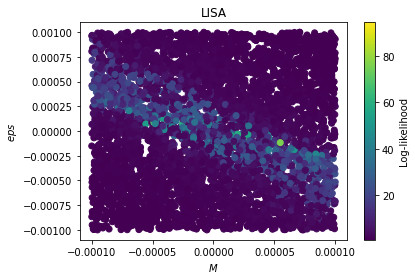

In [51]:
# Plot
plt.scatter(eps_samples, a_samples, c=lls)

plt.xlabel(r"$M$")

plt.ylabel(r"$eps$")
plt.colorbar(label="Log-likelihood")
plt.title(detector)

In [47]:
max(lls)

DeviceArray(94.56008302, dtype=float64)

Text(0.5, 1.0, 'LISA')

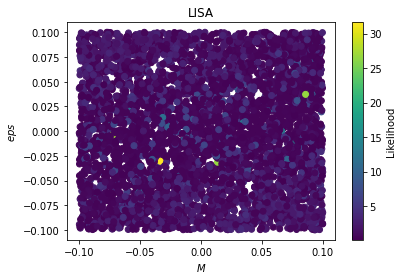

In [50]:
# Plot
plt.scatter(m_samples, q_samples, c=lls)

plt.xlabel(r"$M$")

plt.ylabel(r"$eps$")
plt.colorbar(label="Likelihood")
plt.title(detector)

Text(0.5, 1.0, 'LISA')

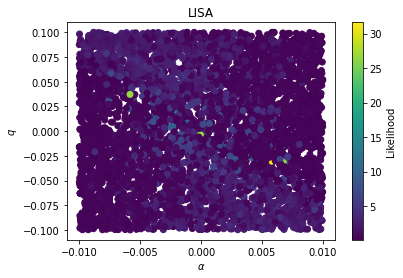

In [47]:
# Plot
plt.scatter(a_samples, q_samples, c=lls)

plt.xlabel(r"$\alpha$")

plt.ylabel(r"$q$")
plt.colorbar(label="Likelihood")
plt.title(detector)

In [48]:
max(lls)

DeviceArray(31.62589722, dtype=float64)

Text(0.5, 1.0, 'LISA')

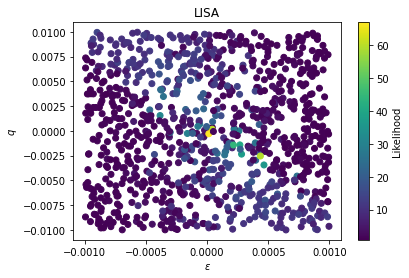

In [25]:
# Plot
plt.scatter(eps_samples, q_samples, c=lls)

plt.xlabel(r"$\epsilon$")

plt.ylabel(r"$q$")
plt.colorbar(label="Likelihood")
plt.title(detector)

Text(0.5, 1.0, 'LISA')

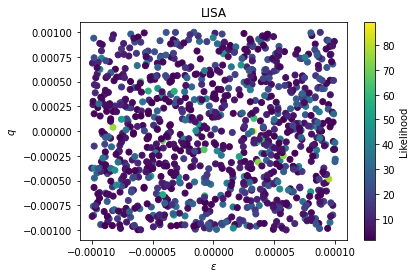

In [28]:
# Plot
plt.scatter(eps_samples, q_samples, c=lls)

plt.xlabel(r"$\epsilon$")

plt.ylabel(r"$q$")
plt.colorbar(label="Likelihood")
plt.title(detector)

In [ ]:
# Plot
plt.scatter(eps_samples, q_samples, c=np.exp(lls))

plt.xlabel(r"$\epsilon$")

plt.ylabel(r"$q$")
plt.colorbar(label="Likelihood")
plt.title(detector)

# Fit with vacuum template

In [48]:
def ptform_v(u):
    assert u.shape == (1,)
    v_m = np.array([10])
    return v_m * (u )


def unpack_v(x):
    dMc_MSUN = x[0]
    Mc = GA_D.M_chirp + dMc_MSUN * MSUN

    m_1 = get_m_1(Mc, GA_D.q)
    f_c = get_f_isco(m_1)
    return VacuumBinary(Mc, GA_D.Phi_c, GA_D.tT_c, GA_D.dL, f_c)


#@jax.jit
def get_ll_fft(x):
    vb_h = unpack_v(x)
    return loglikelihood_fft(vb_h, GA_D, FS, PAD_LOW, PAD_HIGH, S_n)

  0%|          | 0/500 [00:00<?, ?it/s]

Text(0, 0.5, 'Likelihood')

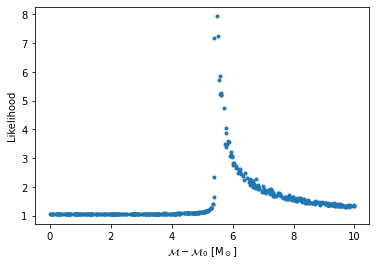

In [49]:
# Sample points and compute likelihood
xs = []
lls = []

for _ in trange(500):
    xs.append(ptform_v(np.random.rand(1)))
    lls.append(get_ll_fft(xs[-1]))

xs = jnp.array(xs)
lls = jnp.array(lls)
# this is q 
plt.plot(xs, jnp.exp(lls), ".")
plt.xlabel(r"$\mathcal{M} - \mathcal{M}_0$ [M$_\odot$]")
plt.ylabel("Likelihood")

In [38]:
# Use 500 - 2000 live points. You need a lot, otherwise you may miss the
# high-likelihood region!
sampler = dynesty.NestedSampler(get_ll_fft, ptform_v, 1, nlive=1000, bound = 'single')
sampler.run_nested()
results_v = sampler.results

3180it [1:37:13,  1.83s/it, +1000 | bound: 0 | nc: 1 | ncall: 24121 | eff(%): 18.079 | loglstar:   -inf <  3.893 <    inf | logz:  0.307 +/-  0.089 | dlogz:  0.002 >  1.009]


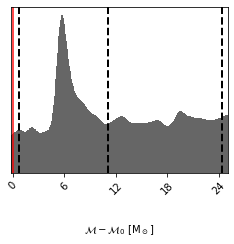

In [46]:
# Plot 2000 live points, ([1])
labels = (
    r"$\mathcal{M} - \mathcal{M}_0$ [M$_\odot$]",
)
# 
quantiles_2d = [1 - np.exp(-(x ** 2) / 2) for x in [1, 2, 3]]
fig, axes = dyplot.cornerplot(
    results_v, labels=labels, quantiles_2d=quantiles_2d, truths=(0,), span = [(-0.19,25)]
)
fig.tight_layout()
fig.savefig('ga_v_fid.pdf')

In [41]:
with open(f"ga-v-fid.pkl", "wb") as output:
    pickle.dump(results_v,output, pickle.HIGHEST_PROTOCOL)

# Bayes factors

In [ ]:
bayes_fact_ns_v = jnp.exp(results.logz[-1]) / jnp.exp(results_v.logz[-1])
sig_fact = sigma prior range from above / 1e9
mach_fact = mach prior range from above / 200
dM_fact = Mc prior range from above / Mc prior range from vacuum fits
bayes_fact_v = dM_fact * sig_fact * mach_fact * bayes_fact_ns

# Fit with dark dress template

In [13]:
def ptform_dd(u):
    assert u.shape == (4,)
    v_m = np.array([10, 0.5, 50, 1])
    return [v_m[0] * u[0], 2 + v_m[1] * u[1], 50 + v_m[2] * (u[2]), -4.5 + v_m[3] * u[3]]


def unpack_dd(x):
    dMc_MSUN = x[0]
    dgs = x[1]
    drho_6 = x[2]
    dq = x[3]
    Mc = GA_D.M_chirp + dMc_MSUN * MSUN
    gamma_s = 7/3
    rho_6 = drho_6 * 1e15 * MSUN / PC ** 3
    q = 10**dq
    m_1 = get_m_1(Mc, q)
    f_c = get_f_isco(m_1)
    return DynamicDress(gamma_s, rho_6, Mc, q, GA_D.Phi_c, GA_D.tT_c, GA_D.dL, f_c)


#@jax.jit
def get_ll_fft(x):
    dd_h = unpack_dd(x)
    return loglikelihood_fft(dd_h, GA_D, FS, PAD_LOW, PAD_HIGH, S_n)

In [20]:
# Sample points and compute likelihood
xs = []
lls = []

for _ in trange(1000):
    xs.append(ptform_dd(np.random.rand(4)))
    lls.append(get_ll_fft(xs[-1]))

xs = jnp.array(xs)
lls = jnp.array(lls)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [21]:
m_samples_dd = []
g_samples = []
rho_samples = []
q_samples_dd = []
for i in range(len(xs)):
    m_samples_dd.append(xs[i][0])
    g_samples.append(xs[i][1])
    rho_samples.append(xs[i][2])
    q_samples_dd.append(xs[i][3])

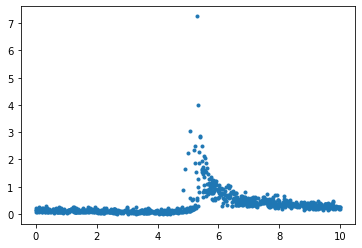

In [22]:
plt.plot(m_samples_dd,lls-lls.min(),".")

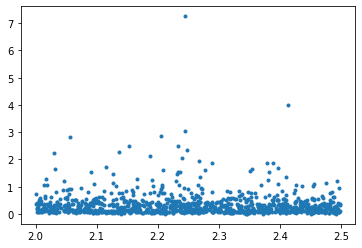

In [23]:
plt.plot(g_samples,lls-lls.min(),".")

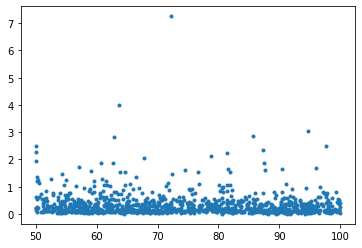

In [24]:
plt.plot(rho_samples,lls-lls.min(),".")

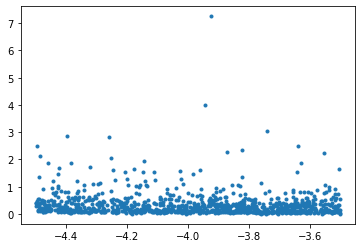

In [25]:
plt.plot(q_samples_dd,lls-lls.min(),".")

In [ ]:
# Use 500 - 2000 live points. You need a lot, otherwise you may miss the
# high-likelihood region!
sampler = dynesty.NestedSampler(get_ll_fft, ptform_dd, 4, nlive=1000, bound = 'single', update_interval = 10000)
sampler.run_nested()
results_dd_new = sampler.results

2834it [59:14,  2.35s/it, bound: 0 | nc: 2 | ncall: 16999 | eff(%): 16.672 | loglstar:   -inf <  1.255 <    inf | logz:  0.506 +/-  0.009 | dlogz:  5.108 >  1.009] 

In [105]:
# Use 500 - 2000 live points. You need a lot, otherwise you may miss the
# high-likelihood region!
sampler = dynesty.NestedSampler(get_ll_fft, ptform_dd, 4, nlive=1000, bound = 'single')
sampler.run_nested()
results_dd = sampler.results

6992it [8:37:57,  4.44s/it, +1000 | bound: 47 | nc: 1 | ncall: 107613 | eff(%):  7.496 | loglstar:   -inf <  8.087 <    inf | logz:  0.873 +/-  0.148 | dlogz:  0.001 >  1.009]


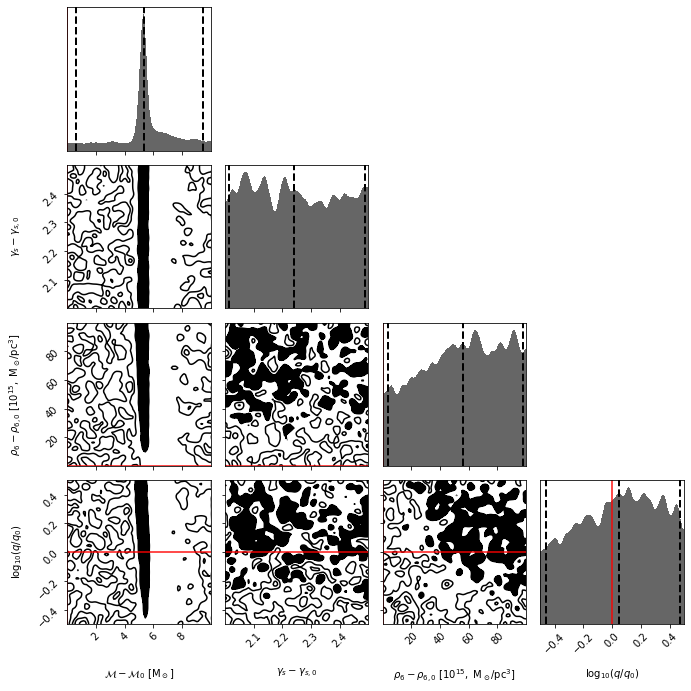

In [234]:
# Plot 1000 live points, ([5e-3,5e-3,5])
labels = (r"$\mathcal{M} - \mathcal{M}_0$ [M$_\odot$]",
    r"$\gamma_s - \gamma_{s,0}$",
    r"$\rho_6 - \rho_{6,0}$ [$10^{15},$ M$_\odot$/pc$^3$]",
          r"$\log_{10}(q/q_0)$"
)
# 
quantiles_2d = [1 - np.exp(-(x ** 2) / 2) for x in [1, 2, 3]]
fig, axes = dyplot.cornerplot(
    results_dd, labels = labels, quantiles_2d=quantiles_2d, truths=(0, 0, 0, 0)
)
fig.tight_layout()

In [272]:
with open(f"ga-dd_wrongq.pkl", "wb") as output:
    pickle.dump(results_dd,output, pickle.HIGHEST_PROTOCOL)

In [ ]:
def ptform_dd(u):
    assert u.shape == (4,)
    v_m = np.array([10, 0.5, 100, 0.5])
    return [v_m[0] * u[0], 2 + v_m[1] * u[1], v_m[2] * (u[2]), 2 * v_m[3] * (u[3] - 0.5)]


def unpack_dd(x):
    dMc_MSUN = x[0]
    dgs = x[1]
    drho_6 = x[2]
    dq = x[3]
    Mc = GA_D.M_chirp + dMc_MSUN * MSUN
    gamma_s = 7/3
    rho_6 = drho_6 * 1e15 * MSUN / PC ** 3
    q = GA_D.q * 10**dq
    m_1 = get_m_1(Mc, q)
    f_c = get_f_isco(m_1)
    return DynamicDress(gamma_s, rho_6, Mc, q, GA_D.Phi_c, GA_D.tT_c, GA_D.dL, f_c)
with open(f"ga-dd.pkl", "wb") as output:
    pickle.dump(results_dd,output, pickle.HIGHEST_PROTOCOL)

# Fit with accretion disc template

In [16]:
def ptform_a(u):
        assert u.shape == (2,)
        v_m = np.array([100,8])
        return np.array([(v_m[0] * u[0]), 8 + (v_m[1] * u[1])])


def unpack(x):
    dMc_MSUN = x[0]
    dsigm2 = x[1]
    Mc = GA_D.M_chirp + dMc_MSUN * MSUN
    sigm2 = 10**dsigm2

    m_1 = get_m_1(Mc, GA_D.q)
    f_c = get_f_isco(m_1)
    return AccretionDisk(sigm2, Mc, GA_D.q, GA_D.Phi_c, GA_D.tT_c, GA_D.dL, f_c)

#@jax.jit
def get_ll_fft(x):
    ad_h = unpack(x)
    return loglikelihood_fft(ad_h, GA_D, FS, PAD_LOW, PAD_HIGH, S_n)

In [14]:
# Sample points and compute likelihood
xs = []
lls = []

for _ in trange(1000):
    xs.append(ptform_a(np.random.rand(2)))
    lls.append(get_ll_fft(xs[-1]))

xs = np.array(xs)
lls = np.array(lls)

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'LISA')

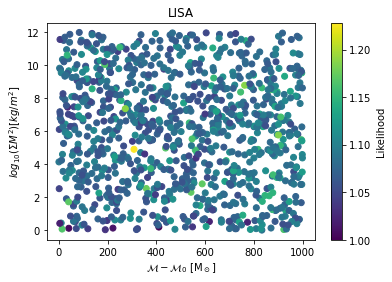

In [20]:
m_samples_ad = []
sigm_samples = []
for i in range(len(xs)):
    m_samples_ad.append(xs[i][0])
    sigm_samples.append(xs[i][1])

In [ ]:
plt.plot(m_samples_ad,lls-lls.min(),".")

In [ ]:
plt.plot(sigm_samples,lls-lls.min(),".")